# Predictive Coding

In [35]:
import numpy as np
import nengo
import matplotlib.pyplot as plt

# `PCLayer` class
This class models both the value nodes and error nodes of a single layer, as well as their interactions.

In [36]:
class PCLayer(nengo.Network):
    '''
     l = PCLayer(n_nodes=10, tau=0.01)
     
     Creates a layer for a predictive-coding network.
     This layer has an array of value nodes, and a corresponding array of error nodes.
     
     Inputs:
      n_nodes  number of nodes in the layer
      tau      synaptic time constant for internal error->value connections
    '''
    def __init__(self, n_nodes=10, tau=0.01):
        tau = 0.01
        self.label = 'PCLayer'
        # When the network is run in using the "Direct" neuron model, it treats
        # each "Ensemble" as a single variable, and the decodings are done by
        # the user-supplied decoding functions, not using decoding weights.
        # In this case, the "n_neurons" argument is ignored.
        
        # An "EnsembleArray" can be thought of as a group of nodes.
        # An EnsembleArray holding the values (v)
        self.v = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=n_nodes, radius=1.5)
        # and an EnsembleArray holding the errors (e)
        self.e = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=n_nodes, radius=1.5)
        
        nengo.Connection(self.v.output, self.v.input, transform=1)               # sustain old state
        nengo.Connection(self.e.output, self.v.input, transform=-1, synapse=tau) # (v)<-(e)
        nengo.Connection(self.v.output, self.e.input)                            # (v)->(e)

# `PCConnection` class
This class models the weighted, all-to-all connections between `PCLayer`s.

In [37]:
class PCConnection(nengo.Network):
    '''
     c = PCConnection(below, above, learn=False, symmetric=True)
     
     This class builds all the connections between the two PCLayers.
     
     Inputs:
      below      PCLayer object below
      above      PCLayer object above
      learn      Boolean, whether to learn (default False)
      symmetric  Boolean, whether the connection is symmetric
                 ie. W = M.T (default True)
    '''
    def __init__(self, below, above, learn=False, symmetric=True, M=None):
        self.below = below
        self.above = above
        self.learn = learn
        self.tau = 10.    # learning time constant
        self.symmetric = symmetric
        self.n_e = self.below.e.n_ensembles  # dimension of below layer
        self.n_v = self.above.v.n_ensembles  # dimension of above layer

        # Set up connect matrices
        if M is None:
            self.M = np.random.normal(size=(self.n_v, self.n_e))/10.
        else:
            self.M = M
        if self.symmetric:
            self.W = self.M.T
        else:
            self.W = np.random.normal(size=(self.n_e, self.above.n_v))
        
        # Set up the node that applies the connection weights
        dims = self.n_e + self.n_v
        self.exchange = nengo.Node(self.update, size_in=dims, size_out=dims)
        
        n = self.n_e
        nengo.Connection(self.below.e.output, self.exchange[:n])               # inp -> exchange
        nengo.Connection(self.exchange[:n], self.below.e.input, transform=-1)  # inp <- con
        nengo.Connection(self.above.v.output, self.exchange[n:], transform=1)  # con <- hid
        nengo.Connection(self.exchange[n:], self.above.v.input)                # con -> hid
        
    def update(self, t, x):
        e_in = x[:self.n_e]
        v_in = x[self.n_e:]

        err_out = self.W @ e_in
        pred_out = self.M @ v_in

        if self.learn:
            dM = np.outer(e_in, v_in)
            self.M += dM / self.tau
            if not self.symmetric:
                self.W += dM.T / self.tau

        return np.concatenate((pred_out, err_out))


In [38]:
# Using PCLayer class
n = 1
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0.05
    
    # Inputs
    stim = nengo.Node([1])   # sensory (bottom layer)
    pred = nengo.Node([1.])  # percept (top layer)
    
    # We need a node that computes the error between stim and the prediction from above.
    stim_err = nengo.Node(lambda t,x: x[0]+x[1], size_in=2, size_out=1)  # sensory error
    
    
    # PC layers
    pc1 = PCLayer(n_nodes=1)
    pc2 = PCLayer(n_nodes=1)
    
    '''
     [     /-->         ] -W-> [      /-->       ] -W-> [      /-->       ]      [      ]
     [ stim     stim_err]      [ pc1.v     pc1.e ]      [ pc2.v     pc2.e ]      [ pred ]
     [                  ] <-M- [       <--/      ] <-M- [       <--/      ] <-M- [      ]
    '''
    
    # Connections
    nengo.Connection(stim, stim_err[0])                       # stim -> stim_err
    nengo.Connection(stim_err, pc1.v.input)                   # stim_err -> pc1
    nengo.Connection(pc1.v.output, stim_err[1], transform=-1) # stim_err <- pc1
    
    # Connect the two PC layers
    pc_con1 = PCConnection(pc1, pc2, learn=False) #, M=np.array([1]))
    
    # Connect top layer to predictions from on high
    nengo.Connection(pred, pc2.e.input, transform=-1)         # pc2 <- pred
    
    
    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    p_pc1v = nengo.Probe(pc1.v.output)
    p_pc1e = nengo.Probe(pc1.e.output)
    p_pc2v = nengo.Probe(pc2.v.output)
    p_pc2e = nengo.Probe(pc2.e.output)
    p_pred = nengo.Probe(pred)

In [39]:
sim = nengo.Simulator(net)

Build finished in 0:00:01.                                                      


In [40]:
sim.run(1.)

Simulation finished in 0:00:01.                                                 


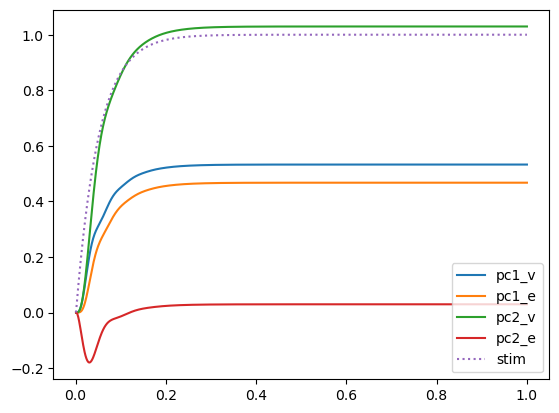

In [41]:
plt.plot(sim.trange(), sim.data[p_pc1v]);
plt.plot(sim.trange(), sim.data[p_pc1e]);
plt.plot(sim.trange(), sim.data[p_pc2v]);
plt.plot(sim.trange(), sim.data[p_pc2e]);
plt.plot(sim.trange(), sim.data[p_stim], ':');
plt.legend(['pc1_v', 'pc1_e', 'pc2_v', 'pc2_e', 'stim']);

In [42]:
pc_con1.learn = True

In [43]:
sim.run(1.)

Simulation finished in 0:00:01.                                                 


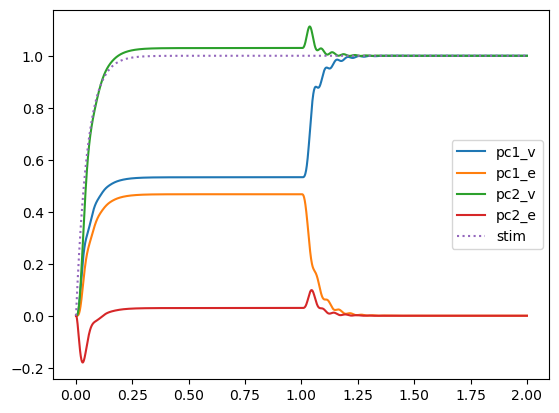

In [44]:
plt.plot(sim.trange(), sim.data[p_pc1v]);
plt.plot(sim.trange(), sim.data[p_pc1e]);
plt.plot(sim.trange(), sim.data[p_pc2v]);
plt.plot(sim.trange(), sim.data[p_pc2e]);
plt.plot(sim.trange(), sim.data[p_stim], ':');
plt.legend(['pc1_v', 'pc1_e', 'pc2_v', 'pc2_e', 'stim']);

# `PCNetwork` class
This class creates a predictive coding neural network made of `PCLayer`s.

In [45]:
class PCNetwork:
    '''
    c = PCNetwork(num_hidden_layers, learn=False, symmetric=True)
    
    This class builds a PC neural network with.
    
    Inputs:
    num_hidden_layers     PCLayer object below
    learn                 Boolean, whether to learn (default False)
    symmetric             Boolean, whether the connection is symmetric
                          ie. W = M.T (default True)
    tau                   num or List, synaptic time constant for internal error->value connections
                            - if num, each layer will have the same tau
                            - if List, each layer will have a tau corresponding to the value in that
                              position in the list
    n_nodes               Int or List, number of nodes at each layer, defaults to 10
                            - if Int, each layer will have the same number of nodes
                            - if List, each layer will have a number of nodes corresponding to the value
                              in that position in the list
    M                     ndarray, List or None, value of M at each layer, defaults to None
                            - if ndarray or None, each layer will have M passed in as an argument during construction
                            - if List, each layer will have an M corresponding to the value in that
                              position in the list
    '''
    def __init__(self, num_hidden_layers, learn=False, symmetric=True, tau=10., n_nodes=10, M=None):
        self.layers = [] #a list of all layers in order of connection
        self.connections = [] #a list of all connections between layers
        self.learn = learn
        self.symmetric = symmetric

        #set up member attributes and input validation
        if type(tau) is int or type(tau) is float:
            self.tau = [tau for i in range(num_hidden_layers)]   # learning time constant
        elif type(tau) is not list:
            raise TypeError(f"tau must be a list or an int/float, instead got {type(tau)}")
        else:
            if len(tau) != num_hidden_layers:
                raise ValueError(f"If tau is a list, it must have num_hidden_layers ({num_hidden_layers}) elements, instead got {len(tau)}")
            self.tau = tau
            
        if type(n_nodes) is int:
            self.n_nodes = [n_nodes for i in range(num_hidden_layers)]
        elif type(n_nodes) is not list:
            raise TypeError(f"n_nodes must be a list or an int, instead got {type(n_nodes)}")
        else:
            if len(n_nodes) != num_hidden_layers:
                raise ValueError(f"If n_nodes is a list, it must have num_hidden_layers ({num_hidden_layers}) elements, instead got {len(n_nodes)}")
            self.n_nodes = n_nodes
        
        if type(M) is np.ndarray or M is None:
            self.M = [M for i in range(num_hidden_layers-1)]
        elif type(M) is not list:
            raise TypeError(f"M must be an ndarray, list, or None, instead got f{type(M)}")
        else:
            if len(M) != num_hidden_layers-1:
                raise ValueError(f"If M is a list, it must have num_hidden_layers-1 ({num_hidden_layers-1}) elements, instead got {len(M)}")
            self.M = M
            
        #create hidden layers
        self.layers.append(PCLayer(n_nodes=self.n_nodes[0], tau=self.tau[0]))
        for i in range(1, num_hidden_layers): #create and connect the rest of the layers
            self.layers.append(PCLayer(n_nodes=self.n_nodes[i], tau=self.tau[i]))
            self.connections.append(PCConnection(self.layers[i-1], 
                                                 self.layers[i], 
                                                 learn=self.learn, 
                                                 symmetric=self.symmetric,
                                                 M=self.M[i-1]))
            
    
    def connect_input(self, stim, stim_err):
        """ (self, nengo.Node, nengo.Node) -> ()
        Connects the input (stimulus) layer to the first hidden layer of the network.
        
        Assumes stim_err has size_in 2, size_out 1
        """
        nengo.Connection(stim, stim_err[0])                                 # stim -> stim_err
        nengo.Connection(stim_err, self.layers[0].v.input)                   # stim_err -> first layer
        nengo.Connection(self.layers[0].v.output, stim_err[1], transform=-1) # stim_err <- first layer
    

    def connect_output(self, pred):
        """ (self, nengo.Node, nengo.Node) -> ()
        Connects the output (prediction) layer to the last hidden layer of the network.
        """
        nengo.Connection(pred, self.layers[-1].e.input, transform=-1)         # pc2 <- pred
    

    def update_learning_rule(self, learning_rule):
        """ (self, bool) -> ()
        Changes the learning rule for each connection is self.connections to learning_rule
        """
        for con in self.connections:
            con.learn = learning_rule

    
    def get_probes(self):
        """ (self) -> (list, list)
        Returns a list of nengo.Probes to track each layers values and errors.
        """
        val_probes = []
        err_probes = []
        for idx, layer in enumerate(self.layers):
            val_probes.append(nengo.Probe(layer.v.output, label=f"Hidden Layer {idx} Value"))
            err_probes.append(nengo.Probe(layer.e.output, label=f"Hidden Layer {idx} Error"))
        return val_probes, err_probes

        

In [46]:
# same test as before but using the PCNetwork class
n = 1
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0.05
    
    # Inputs
    stim = nengo.Node([1])   # sensory (bottom layer)
    pred = nengo.Node([1.])  # percept (top layer)
    
    # We need a node that computes the error between stim and the prediction from above.
    stim_err = nengo.Node(lambda t,x: x[0]+x[1], size_in=2, size_out=1)  # sensory error
    
    
    # PC layers
    PC_net = PCNetwork(2, learn=False, tau=tau, n_nodes=1)
    PC_net.connect_input(stim=stim, stim_err=stim_err)
    PC_net.connect_output(pred=pred)
    '''
     [     /-->         ] -W-> [      /-->       ] -W-> [      /-->       ]      [      ]
     [ stim     stim_err]      [ pc1.v     pc1.e ]      [ pc2.v     pc2.e ]      [ pred ]
     [                  ] <-M- [       <--/      ] <-M- [       <--/      ] <-M- [      ]
    '''
    
 
    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    p_pc1v = nengo.Probe(PC_net.layers[0].v.output)
    p_pc1e = nengo.Probe(PC_net.layers[0].e.output)
    p_pc2v = nengo.Probe(PC_net.layers[1].v.output)
    p_pc2e = nengo.Probe(PC_net.layers[1].e.output)
    p_pred = nengo.Probe(pred)

In [47]:
sim = nengo.Simulator(net)

Build finished in 0:00:01.                                                      


In [48]:
sim.run(1.)

Simulation finished in 0:00:01.                                                 


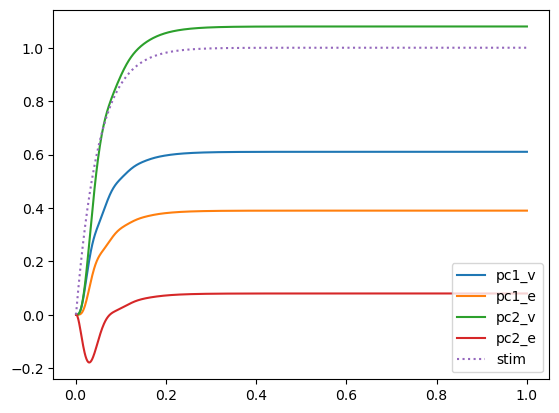

In [49]:
plt.plot(sim.trange(), sim.data[p_pc1v]);
plt.plot(sim.trange(), sim.data[p_pc1e]);
plt.plot(sim.trange(), sim.data[p_pc2v]);
plt.plot(sim.trange(), sim.data[p_pc2e]);
plt.plot(sim.trange(), sim.data[p_stim], ':');
plt.legend(['pc1_v', 'pc1_e', 'pc2_v', 'pc2_e', 'stim']);

In [50]:
PC_net.update_learning_rule(True)

In [51]:
sim.run(1.)

Simulation finished in 0:00:01.                                                 


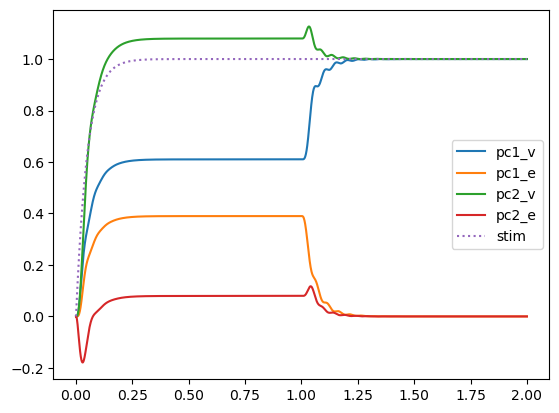

In [52]:
plt.plot(sim.trange(), sim.data[p_pc1v]);
plt.plot(sim.trange(), sim.data[p_pc1e]);
plt.plot(sim.trange(), sim.data[p_pc2v]);
plt.plot(sim.trange(), sim.data[p_pc2e]);
plt.plot(sim.trange(), sim.data[p_stim], ':');
plt.legend(['pc1_v', 'pc1_e', 'pc2_v', 'pc2_e', 'stim']);